#**Apply SHAP to Dog-Cat Classifier**

Mount Google Drive folder.

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load data using TF Dataset pipelines.

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory

# Again, we need this to be TF v1.0 compatible for SHAP to Work.
# Eager execution means we can work with tensors more easily, e.g., convert to numpy on the fly.
tf.compat.v1.disable_v2_behavior()
tf.compat.v1.enable_eager_execution()


base_dir = "drive/My Drive/Teaching/Courses/BA 865/BA865-2022/Week 5/datasets/dogs-vs-cats"
  
train_dataset = image_dataset_from_directory(
    base_dir + "/train/",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    base_dir + "/validation/",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    base_dir + "/test/",
    image_size=(180, 180),
    batch_size=32)

Instructions for updating:
non-resource variables are not supported in the long term
Found 765 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
Found 798 files belonging to 2 classes.


Define model...

In [ ]:
from tensorflow import keras 
from keras import layers

data_augmentation = keras.Sequential([
   layers.RandomFlip("horizontal"),
   layers.RandomRotation(0.1),
   layers.RandomZoom(0.2),
])
  
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     multiple                  0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                             

Fit the model with a callback...

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="drive/My Drive/Teaching/Courses/BA 865/BA865-2022/Week 5/convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=40,
    validation_data=validation_dataset,
    callbacks=callbacks)

Train on 24 steps, validate on 13 steps
Epoch 1/40
24/24 [==============================] - ETA: 0s - batch: 11.5000 - size: 1.0000 - loss: 0.8044 - acc: 0.5137

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


24/24 [==============================] - 4s 74ms/step - batch: 11.5000 - size: 1.0000 - loss: 0.8044 - acc: 0.5137 - val_loss: 0.6920 - val_acc: 0.5000
Epoch 2/40
24/24 [==============================] - 1s 40ms/step - batch: 11.5000 - size: 1.0000 - loss: 0.6932 - acc: 0.5412 - val_loss: 0.6926 - val_acc: 0.5000
Epoch 3/40
24/24 [==============================] - 1s 42ms/step - batch: 11.5000 - size: 1.0000 - loss: 0.6987 - acc: 0.5490 - val_loss: 0.6903 - val_acc: 0.5325
Epoch 4/40
24/24 [==============================] - 1s 40ms/step - batch: 11.5000 - size: 1.0000 - loss: 0.7155 - acc: 0.5542 - val_loss: 0.6919 - val_acc: 0.5000
Epoch 5/40
24/24 [==============================] - 1s 42ms/step - batch: 11.5000 - size: 1.0000 - loss: 0.6865 - acc: 0.5908 - val_loss: 0.6692 - val_acc: 0.6250
Epoch 6/40
24/24 [==============================] - 1s 45ms/step - batch: 11.5000 - size: 1.0000 - loss: 0.7479 - acc: 0.6458 - val_loss: 0.6504 - val_acc: 0.6500
Epoch 7/40
24/24 [===============

As before, this model gets to about 70% accuracy in the test data.

In [ ]:
test_model = keras.models.load_model("drive/My Drive/Teaching/Courses/BA 865/BA865-2022/Week 5/convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset) 
print(f"Test accuracy: {test_acc}")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Test accuracy: 0.7067669034004211


#**SHAP Gradient Explainer**

In [ ]:
!pip install shap
import shap
import numpy as np
import glob
from PIL import Image

# Let's get 50 cats. 
images = []
ind = 0
for file in glob.glob(f"{base_dir}/train/cats/*"):
    im=Image.open(file)
    im=im.resize(size=(180,180))
    images.append(np.divide(np.array(im),255))
    ind += 1
    if ind == 50:
      break

# Let's also get 50 dogs. 
ind = 0
for file in glob.glob(f"{base_dir}/train/dogs/*"):
    im=Image.open(file)
    im=im.resize(size=(180,180))
    images.append(np.divide(np.array(im),255))
    ind += 1
    if ind == 50:
      break

background = np.stack(images)

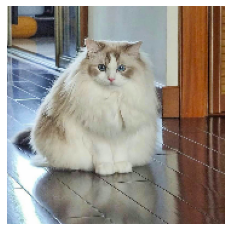

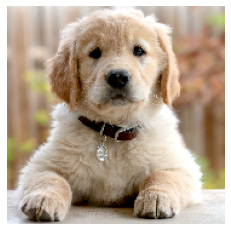

In [ ]:
import matplotlib.pyplot as plt

# explain predictions of the model on three images
e = shap.GradientExplainer(test_model, background)

cat_path = keras.utils.get_file(
    fname="cat6.jpg",
    origin="https://www.brightstarbuddies.com.au/blog/wp-content/uploads/sites/8/Bellamy.jpg")
 
dog_path = keras.utils.get_file(
    fname="dog.jpeg",
    origin="https://kb.rspca.org.au/wp-content/uploads/2018/11/golder-retriever-puppy.jpeg"
)

def get_img_array(img_path, target_size):
    img = keras.utils.load_img(
        img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array
  
cat_tensor = get_img_array(cat_path, target_size=(180, 180))
dog_tensor = get_img_array(dog_path, target_size=(180, 180))

plt.axis("off")
plt.imshow(cat_tensor[0].astype("uint8"))
plt.show()
plt.axis("off")
plt.imshow(dog_tensor[0].astype("uint8"))
plt.show()

shap_values_cat = e.shap_values(cat_tensor)
shap_values_dog = e.shap_values(dog_tensor)

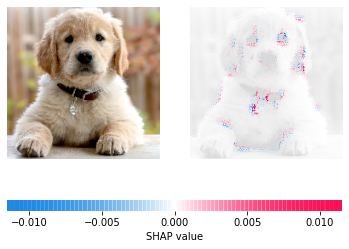

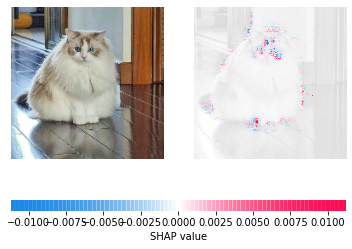

[[0.6597036]]
[[0.12923881]]


`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


In [ ]:
shap.image_plot(shap_values_dog, dog_tensor)
shap.image_plot(shap_values_cat, cat_tensor)
print(model.predict(dog_tensor))
print(model.predict(cat_tensor))